# FAISS on Market1501 Dataset (512-dimensions)

Images from a public person re-identification dataset called Market1501 which contains around 32000 low-resolution surveillance images of people. Generic embeddings have been generated using ResNet, which results in 512 dimensional vectors per image. 

In [1]:
import numpy as np
import csv
import faiss
import time
import matplotlib.pyplot as plt
from PIL import Image

from os import listdir
from os.path import isfile, join, splitext

Load in the dataset provided.

In [3]:
embeddings_folder = 'data/512d_embedding'
image_folder = 'data/images'

files = [file for file in listdir(embeddings_folder) if isfile(join(embeddings_folder, file))]
print(files[0:10])

['00001480_01_0001.txt', '00001312_01_0001.txt', '00000001_04_0000.txt', '00001403_00_0005.txt', '00001308_02_0003.txt', '00000307_05_0009.txt', '00001219_02_0000.txt', '00000227_05_0035.txt', '00001096_02_0001.txt', '00001386_02_0001.txt']


Load in all the vectors from the combined txt file generated earlier.

In [27]:
file_allresults = 'all_results.txt'

start = time.time()
arr_raw = np.genfromtxt(join(embeddings_folder, file_allresults), delimiter=",")
print('Time taken : ', time.time() - start)

# remove last column nan data (due to trailing comma)
vectors_only = arr_raw[:, 0:512]

Time taken :  18.659420490264893


Load in the filenames from the combined filenames.txt.

In [28]:
filenames = 'filenames.txt'
%time arr_filenames = np.genfromtxt(join(embeddings_folder, filenames), delimiter="\n", dtype=str)

arr_filenames.shape

CPU times: user 97.7 ms, sys: 4.09 ms, total: 102 ms
Wall time: 102 ms


(32217,)

Save the numpy arrays as .npy files to be loaded in more quickly in future.

In [67]:
np.save('data/pg_512d_vectors.npy', vectors_only)
np.save('data/pg_512d_filenames.npy', arr_filenames)

In [68]:
# load np
vectors_only = np.load('data/pg_512d_vectors.npy')
arr_filenames = np.load('data/pg_512d_filenames.npy')

In [69]:
vectors_only.shape

(32217, 512)

Construct search space and query vector to run similarity against.

In [70]:
%time xb = vectors_only.astype('float32')
xq = xb[1000:1001]  # set query vector. Take a random one from the dataset

print('xb.shape : ',xb.shape)
print('xq.shape: ', xq.shape)

CPU times: user 17.5 ms, sys: 32.1 ms, total: 49.5 ms
Wall time: 48.8 ms
xb.shape :  (32217, 512)
xq.shape:  (1, 512)


Create index and add vectors to index. We use HNSW, which has the highest recall vs search speed performance, but uses more memory (bytes/vector): https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

Measure the time to index as well. Wall time is the actual time it took. Note that CPU time can be more than wall time if it is being processed by multiple CPUs at once.

In [71]:
d = 512 # Number of dimensions

index = faiss.IndexHNSWFlat(d, 25) # https://github.com/nmslib/nmslib/blob/master/python_bindings/parameters.md
# index.hnsw.efConstruction = 40 # Increasing this will increase recall but also indexing time
print('index.is_trained : ', index.is_trained)

%time index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
CPU times: user 59.6 s, sys: 41.6 ms, total: 59.6 s
Wall time: 29.9 s
index.ntotal :  32217


Save the index to a file which can be quickly re-loaded later on.
See https://github.com/facebookresearch/faiss/wiki/Index-IO,-index-factory,-cloning-and-hyper-parameter-tuning

In [72]:
faiss.write_index(index, "pg_512d_hnsw.index")

Perform search for top k nearest neighbours.

In [75]:
k = 11                         # we want to see 10 nearest neighbors
%time D, I = index.search(xq, k)     # actual search
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])

CPU times: user 559 µs, sys: 21 µs, total: 580 µs
Wall time: 327 µs
I[:5] :  [[1000 1820  779 1233  889 2079 1010 1338 1949  609 1036]]
D[:5] :  [[  0.      163.45505 179.30438 183.99696 184.57861 188.51906 191.8958
  193.6255  196.87056 197.46207 198.24529]]


In [76]:
result = np.empty([0,512])
i = 0
for i in range(k):
    print('index : ', I[0,i], '\ndistance : ', D[0,i], '\narr : ', xb[I[0,i]])
    result = np.vstack((result, xb[I[0,i]]))

result.shape

index :  1000 
distance :  0.0 
arr :  [0.4586416  0.67784727 0.3147152  0.09854365 0.30675787 1.1874893
 0.8114652  3.3652432  0.47019967 2.703279   0.06272431 1.2889699
 1.0595361  0.6111497  0.99698216 0.9733122  0.20384653 0.6262331
 0.57711554 0.8522344  1.0072622  0.3149422  0.05452296 0.03799955
 0.33256814 0.42586964 1.6293833  3.1840057  0.4056889  1.5663712
 0.6260039  0.40183085 0.5761267  1.169321   0.19882594 0.17061329
 1.4576828  0.21707666 2.3687823  0.8397518  0.43281844 1.3574421
 1.4483432  1.3489717  0.13435946 0.40982726 0.8665805  0.15089063
 0.4723563  0.77266675 0.53890073 0.09978586 0.01794745 0.9207774
 0.05596575 1.6848205  0.50490296 0.4528439  2.7920039  0.72490317
 0.11763291 2.2331622  1.4015242  1.4551071  0.72450405 0.45186046
 0.43649298 0.8105871  0.5207113  0.95957667 0.56020874 0.05464152
 0.3181755  1.6579438  0.5455204  0.         0.9454756  0.82132065
 0.5845775  2.9862287  0.38602287 0.6713024  1.0917085  0.87020606
 0.7071578  1.3112828  1.5075

(11, 512)

View the results visually.

In [17]:
def get_map_image_filename(idx):
    image_filename = arr_filenames[idx,]
    print(image_filename)
    image_filename = image_filename + '.jpg'
    return image_filename

In [18]:
def draw_vector_map_image(I):
    plt.figure(figsize=(len(I[0])*4,4))
    for index, (array_index) in enumerate(zip(I[0])):
        fname = get_map_image_filename(array_index[0])
        im = Image.open(join(image_folder, fname))
        plt.subplot(1, len(I[0]), index+ 1)
        plt.imshow(im)
        titlestr = 'i:' + str(array_index[0]) + '  filename:', fname
        plt.title(titlestr, fontsize = 10)

00000000_01_0376
00000000_03_0335
00000000_01_0155
00000000_02_0125
00000000_01_0265
00000000_04_0119
00000000_01_0386
00000000_02_0230
00000000_03_0464
00000000_00_0609
00000000_01_0412


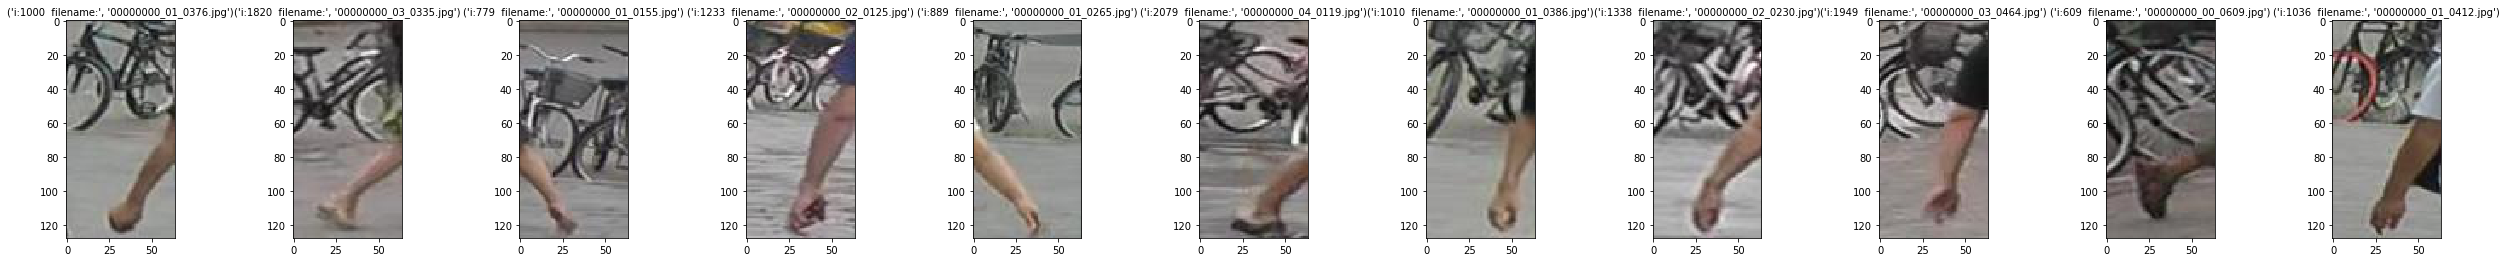

In [79]:
draw_vector_map_image(I) # Where I is the indexes of the top images.

# FAISS on Market1501 Dataset (4096-dimensions)

Images from a public person re-identification dataset called Market1501 which contains around 32000 low-resolution surveillance images of people. Generic embeddings have been generated using AlexNet, which results in 4096 dimensional vectors per image. 

Load in the dataset provided.

In [2]:
embeddings_folder = 'data/4096d_embedding'
image_folder = 'data/images'

files = [file for file in listdir(embeddings_folder) if isfile(join(embeddings_folder, file))]
print(files[0:10])

['00001480_01_0001.txt', '00001312_01_0001.txt', '00000001_04_0000.txt', '00001403_00_0005.txt', '00001308_02_0003.txt', '00000307_05_0009.txt', '00001219_02_0000.txt', '00000227_05_0035.txt', '00001096_02_0001.txt', '00001386_02_0001.txt']


Load in to 2 arrays - one for vectors and one for filenames.

In [4]:
file_allresults = 'all_results.txt'

# Needed to resize from D2s_v3 to D4s_v3 to run the below line
%time arr_raw = np.genfromtxt(join(embeddings_folder, file_allresults), delimiter=",")


CPU times: user 2min 44s, sys: 7.4 s, total: 2min 51s
Wall time: 2min 51s


In [5]:
# remove last column nan data (due to trailing comma)
vectors_only = arr_raw[:, 0:4096]
vectors_only.shape

(32217, 4096)

Load in the filenames from the combined filenames.txt.

In [6]:
filenames = 'filenames.txt'
%time arr_filenames = np.genfromtxt(join(embeddings_folder, filenames), delimiter="\n", dtype=str)

arr_filenames.shape

CPU times: user 88.5 ms, sys: 4.02 ms, total: 92.5 ms
Wall time: 89.6 ms


(32217,)

Construct search space and query vector to run similarity against.

In [7]:
%time xb = vectors_only.astype('float32')
xq = xb[1000:1001]  # set query vector. Take a random one from the dataset

print('xb.shape : ',xb.shape)
print('xq.shape: ', xq.shape)

CPU times: user 165 ms, sys: 4.06 ms, total: 169 ms
Wall time: 167 ms
xb.shape :  (32217, 4096)
xq.shape:  (1, 4096)


Build the index.

In [8]:
d = 4096 # Number of dimensions

index = faiss.IndexHNSWFlat(d, 25) # https://github.com/nmslib/nmslib/blob/master/python_bindings/parameters.md
# index.hnsw.efConstruction = 40 # Increasing this will increase recall but also indexing time
print('index.is_trained : ', index.is_trained)

%time index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
CPU times: user 3min 16s, sys: 188 ms, total: 3min 16s
Wall time: 49.6 s
index.ntotal :  32217


In [10]:
faiss.write_index(index, "indexes/pg_4096d_hnsw.index")

In [11]:
index = faiss.read_index("indexes/pg_4096d_hnsw.index")

Perform a search over the index.

In [17]:
k = 11                         # we want to see 10 nearest neighbors
%time D, I = index.search(xq, k)     # actual search
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])

CPU times: user 9.3 ms, sys: 0 ns, total: 9.3 ms
Wall time: 4.16 ms
I[:5] :  [[1000 1073  889  852 1010  853 1107 1043  775  896 1820]]
D[:5] :  [[   0.     1322.3368 1465.3918 1641.0941 1660.0422 1709.7405 1766.0347
  1855.9387 1940.5964 1951.7795 1958.4877]]


View the results for the nearest neighbours - print the index, distance from the query image, and the actual vector.

In [15]:
result = np.empty([0,d])
i = 0
for i in range(k):
    print('index : ', I[0,i], '\ndistance : ', D[0,i], '\narr : ', xb[I[0,i]])
    result = np.vstack((result, xb[I[0,i]]))

result.shape

index :  1000 
distance :  0.0 
arr :  [0.         0.         0.         ... 0.         0.         0.09642782]
index :  1073 
distance :  1322.3368 
arr :  [0.58725804 0.         0.         ... 0.         0.         0.        ]
index :  889 
distance :  1465.3918 
arr :  [0. 0. 0. ... 0. 0. 0.]
index :  852 
distance :  1641.0941 
arr :  [0.        1.9630443 0.        ... 0.        0.        0.       ]
index :  1010 
distance :  1660.0422 
arr :  [0. 0. 0. ... 0. 0. 0.]
index :  853 
distance :  1709.7405 
arr :  [0. 0. 0. ... 0. 0. 0.]
index :  1107 
distance :  1766.0347 
arr :  [0. 0. 0. ... 0. 0. 0.]
index :  1043 
distance :  1855.9387 
arr :  [0.40890157 0.         0.         ... 0.         0.         0.        ]
index :  775 
distance :  1940.5964 
arr :  [0.        2.3392317 0.        ... 0.        0.        0.       ]
index :  896 
distance :  1951.7795 
arr :  [0.        0.        0.8294674 ... 0.        0.        0.       ]
index :  1820 
distance :  1958.4877 
arr :  [1.463

(11, 4096)

See results visually.

00000000_01_0376
00000000_01_0449
00000000_01_0265
00000000_01_0228
00000000_01_0386
00000000_01_0229
00000000_01_0483
00000000_01_0419
00000000_01_0151
00000000_01_0272
00000000_03_0335


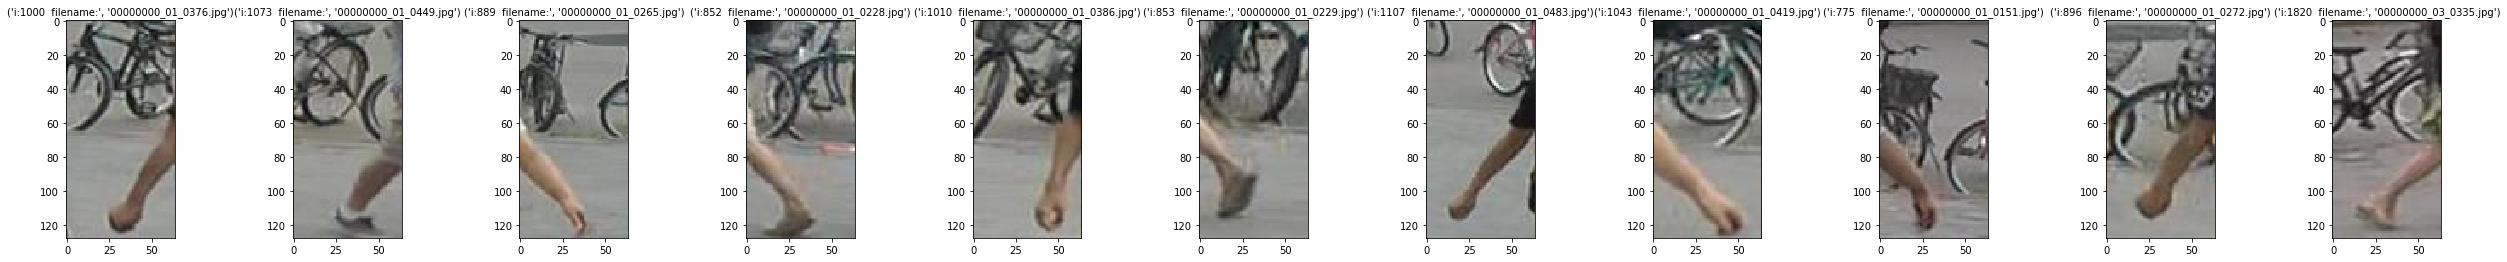

In [19]:
draw_vector_map_image(I) # Where I is the indexes of the top images.